# Housing Sale Price Predictions

### Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest, RFE, RFECV

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import svm

from itertools import combinations

%matplotlib inline

### Load the Data:

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Cleaning:

In [3]:
# Columns I'm dropping becaus they contain the same value for more than about 90% of the data
initial_drop_list = ['Id', 'PID', 'Alley', 'Street', 'Land Contour', 'Utilities', 'Mas Vnr Area',
                    'Land Slope', 'Condition 2', 'Roof Matl', 'Electrical', 'Functional', 'Paved Drive',
                    'Fence', 'Misc Feature', 'Misc Val', 'Sale Type', 'Garage Cond', 'Garage Qual', 'Kitchen AbvGr',
                    'Pool QC', 'Pool Area', 'Low Qual Fin SF', 'Screen Porch', '3Ssn Porch', 'Enclosed Porch',
                    'Open Porch SF', 'Wood Deck SF', 'Garage Yr Blt', '2nd Flr SF', 'Central Air',
                    'Heating', 'BsmtFin SF 2', 'BsmtFin Type 2', 'Bsmt Cond', 'Fireplace Qu']

# Things I'm dropping to reduce multicollinearity with predictors I think are more important
also_drop = ['Mas Vnr Type', 'Bsmt Exposure', 'Garage Area', 'Exterior 1st', 'Exterior 2nd', 'BsmtFin SF 1',
             'Bsmt Unf SF', 'Total Bsmt SF', 'BsmtFin Type 1']

# Add the two lists together
initial_drop_list = initial_drop_list + also_drop

# Make a new df by dropping all these columns
df = train.drop(initial_drop_list, axis = 1)
test_df = test.drop(initial_drop_list, axis = 1)

# also drop 'SalePrice' because it is the target
df.drop('SalePrice', axis = 1, inplace =True)

### Remove Null Values:

In [4]:
# After looking at the Nan observations, these Nan values are actually supposed to be 0 or 'None'
nan_0_cols = ['Lot Frontage', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']

nan_none_cols = ['Bsmt Qual', 'Garage Type', 'Garage Finish']

df[nan_0_cols] = df[nan_0_cols].fillna(value = 0)
test_df[nan_0_cols] = test_df[nan_0_cols].fillna(value = 0)

df[nan_none_cols] = df[nan_none_cols].fillna(value = 'None')
test_df[nan_none_cols] = test_df[nan_none_cols].fillna(value = 'None')

# Feature Engineering:

### Calculate Age:

In [5]:
# Calculate age of building and drop 'Year Built'
df['Age'] = df['Yr Sold'] - df['Year Built']
df.drop(columns=['Year Built'], axis = 1, inplace=True)

test_df['Age'] = test_df['Yr Sold'] - test_df['Year Built']
test_df.drop(columns=['Year Built'], axis = 1, inplace=True)

### Total Baths:

In [6]:
# Calculate total baths and drop the columns its derived from
df['Total Baths'] = df['Full Bath'] + df['Half Bath']/2 + df['Bsmt Full Bath'] + df['Bsmt Half Bath']/2
df.drop(columns=['Half Bath', 'Full Bath', 'Bsmt Half Bath', 'Bsmt Full Bath'], axis = 1, inplace=True)

test_df['Total Baths'] = test_df['Full Bath'] + test_df['Half Bath']/2 + test_df['Bsmt Full Bath'] + test_df['Bsmt Half Bath']/2
test_df.drop(columns=['Half Bath', 'Full Bath', 'Bsmt Half Bath', 'Bsmt Full Bath'], axis = 1, inplace=True)

### Calculate number of months since start of first sale year:

In [7]:
# Calculate number of months since start of first sale year
df['Mo Sold After 1/1/2006'] = (df['Yr Sold'] - 2006) * 12 + df['Mo Sold']
df.drop(columns=['Mo Sold'], axis = 1, inplace=True)

test_df['Mo Sold After 1/1/2006'] = (test_df['Yr Sold'] - 2006) * 12 + test_df['Mo Sold']
test_df.drop(columns=['Mo Sold'], axis = 1, inplace=True)

### Change remodel year to years since remodel:
The data will show age built if there was no remodel

In [8]:
# change remodel year to years since remodel, the data will show age built if there was no remodel
df['Yrs since Remodel'] = df['Yr Sold'] - df['Year Remod/Add']
df.drop(columns=['Yr Sold', 'Year Remod/Add'], axis = 1, inplace=True)

test_df['Yrs since Remodel'] = test_df['Yr Sold'] - test_df['Year Remod/Add']
test_df.drop(columns=['Yr Sold', 'Year Remod/Add'], axis = 1, inplace=True)

### Calculate non-bdrm rooms abvgrd from bedrooms and rooms to reduce structural multicollinearity

In [9]:
# calculate non-bdrm rooms abvgrd from bedrooms and rooms to reduce structural multicollinearity
df['Non-bdrm Rooms AbvGrd'] = df['TotRms AbvGrd'] - df['Bedroom AbvGr']
df.drop(columns=['TotRms AbvGrd'], axis = 1, inplace=True)

test_df['Non-bdrm Rooms AbvGrd'] = test_df['TotRms AbvGrd'] - test_df['Bedroom AbvGr']
test_df.drop(columns=['TotRms AbvGrd'], axis = 1, inplace=True)

### Make Dummy Categorical Features:

In [10]:
# which columns need dummies?

all_pre_dummy_features = list(df.columns)

obj_dummies = list(df.select_dtypes(include=['object']).columns)  # find all columns with object dtypes
extra_dummies = ['MS SubClass', 'Overall Qual', 'Overall Cond']    # these are numeric columns that need dummy variables

df[extra_dummies] = df[extra_dummies].astype('str')
need_dummies = obj_dummies + extra_dummies

# make a list of the columns that aren't dummies
not_dummies = [x for x in df.columns if x not in need_dummies]

#make a list of dummies that you want to look at interactions of and remove from need_dummies
look_at_interact = ['Neighborhood', 'Overall Qual', 'Overall Cond']
need_dummies = [item for item in need_dummies if item not in look_at_interact]

In [11]:
# Make the dummy variables as a seperate df
dummy_df = pd.get_dummies(df[need_dummies], columns = need_dummies, drop_first=True)

dummy_test_df = pd.get_dummies(test_df[need_dummies], columns = need_dummies, drop_first=True)

In [12]:
# update df with dummy variables of look_at_interact list
pre_interact_df = pd.get_dummies(df[(not_dummies + look_at_interact)], columns = look_at_interact, drop_first=True)

test_pre_interact_df = pd.get_dummies(test_df[(not_dummies + look_at_interact)], columns = look_at_interact, drop_first=True)

add_interact_dummies = ['Neighborhood_GrnHill', 'Neighborhood_Landmrk', 'Overall Qual_2']

# make new dummy columns in test set and set them to 0
for col_name in add_interact_dummies:
    test_pre_interact_df[col_name] = 0

# Polynomial Interaction Features:

In [13]:
# make interaction terms
pf = PolynomialFeatures(include_bias = False)
poly_df = pf.fit_transform(pre_interact_df)
column_names = pf.get_feature_names(pre_interact_df.columns)
poly_df = pd.DataFrame(poly_df, columns = column_names)

# do the same thing for the test set
pf = PolynomialFeatures(include_bias = False)
test_poly_df = pf.fit_transform(test_pre_interact_df)
test_poly_df = pd.DataFrame(test_poly_df, columns = column_names)

# Scaling:

In [14]:
# Scaling
ss = StandardScaler()

scaled_df = ss.fit_transform(poly_df)
scaled_df = pd.DataFrame(scaled_df, columns=poly_df.columns)

test_scaled_df = ss.transform(test_poly_df)
test_scaled_df = pd.DataFrame(test_scaled_df, columns=test_poly_df.columns)

In [15]:
#add the dummies to the scaled dfs
scaled_df = pd.concat([scaled_df, dummy_df], axis = 1)
test_scaled_df = pd.concat([test_scaled_df, dummy_test_df], axis = 1)

In [16]:
# make a list of the dummy columns from training set not in test set
add_dummies = ['MS Zoning_C (all)', 'Heating QC_Po', 'MS SubClass_150', 'MS SubClass_20']

# make new dummy columns in test set and set them to 0
for col_name in add_dummies:
    test_scaled_df[col_name] = 0

 # Select Features:

In [17]:
# get features list from training data, except 'SalePrice'
all_features = list(scaled_df.columns)
features = all_features
features.remove('Gr Liv Area Garage Cars')

In [18]:
# make sure test_scaled_df has the same features as scaled_df
test_scaled_df = test_scaled_df[features]

In [19]:
# Create X predictor matrix and target
X = scaled_df[features]
y = train['SalePrice']

# Modeling Function: 
---

The following are necessary to save the results:

In [20]:
index_labels = ['Test score','Train score', 'Best Params', 'Params Tried', 'Notes'] # 'Sensitivity', 'Specificity', 'Precision'

all_results = pd.DataFrame(index=index_labels)
# all_params = pd.DataFrame(columns = ['Parameters'])

# set dataframe options to display long strings rather than truncating them
pd.set_option('display.max_colwidth', 10000)

In [21]:
def fit_model(model, model_name, params, all_results, notes):
    start_time = time.time() # watch the clock

    # train-test-split the training data
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = .3, random_state=None)
    
    # fit the model
    model = GridSearchCV(model, params, n_jobs=-1, cv = 3)
    model.fit(X_train, y_train)
    
    # pick out the best model
    best_model = model.best_estimator_
    
    # make predictions
    pred = best_model.predict(X_holdout)
    
    # Calculate results
    index_labels = ['Test score', 'Train score', 'Best Params', 'Params Tried', 'Notes'] # 'Sensitivity', 'Specificity', 'Precision'
    result = pd.DataFrame(index = index_labels, columns=[model_name])
    result.loc['Test score'][model_name] = round(best_model.score(X_holdout, y_holdout), 3)
    result.loc['Train score'][model_name] = round(model.best_score_, 3)
    result.loc['Best Params'][model_name] = model.best_params_
    result.loc['Params Tried'][model_name] = params
    result.loc['Notes'][model_name] = notes

    display(result.head(2)) # display test results
    display(result.tail(3)) # display parameters and notes

    # add results and params to all_results and all_params
    all_results = pd.concat([all_results, result], axis=1)
    
    # plot actual vs. predicted
    fig, ax = plt.subplots(figsize=(8,6))
    plt.scatter(y_holdout, pred)
    ax.set_xlabel('True Values', size = 20)
    ax.set_ylabel('Predictions', size = 20)
    plt.title('Predictions vs. Actual', size = 20)
    ax.grid()
    plt.plot([0, 600000], [0, 600000], 'k--', lw=3)
    
    # print the runtime
    end_time = time.time()
    print('Runtime: ', round((end_time - start_time)/60, 3), ' minutes')
    
    return all_results, best_model, pred # all_params

# Model Mania!!!

### Random Forest

,Random Forest
Test score,0.853
Train score,0.863


,Random Forest
Best Params,"{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100}"
Params Tried,"{'n_estimators': [100], 'min_samples_split': [7], 'min_samples_leaf': [2], 'bootstrap': [True], 'max_depth': [None], 'max_leaf_nodes': [None], 'max_features': ['auto']}"
Notes,"Picked min_samples_leaf=1, bootstrap=True, n_estimators=100, min_samples_leaf=2"


Runtime:  0.619  minutes


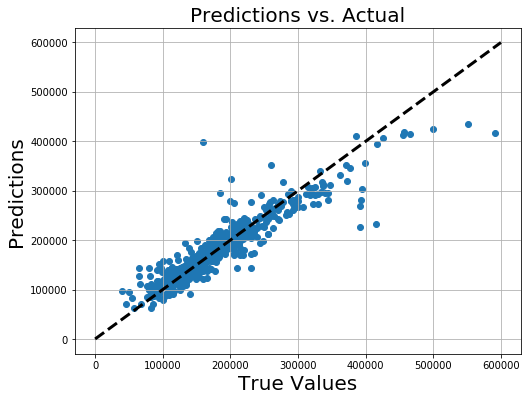

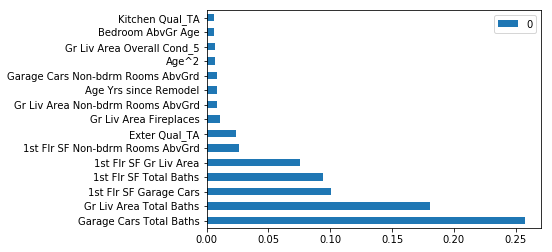

In [22]:
# set parameters
rf_params = {
            'n_estimators': [100],
            'min_samples_split': [7],
            'min_samples_leaf': [2],
            'bootstrap': [True],
            'max_depth':[None],
            'max_leaf_nodes': [None],
            'max_features': ['auto'], # max_feat_to_check
}

rf_notes = 'Picked min_samples_leaf=1, bootstrap=True, n_estimators=100, min_samples_leaf=2'

# call the fit_model function
all_results, rf_best_model, rf_preds = fit_model(RandomForestRegressor(), 
                                                 'Random Forest', 
                                                 rf_params, 
                                                 all_results, 
                                                 rf_notes
                                                )

# Top features
feat_importance = pd.DataFrame(rf_best_model.feature_importances_, index=all_features).sort_values(by=0, ascending=False)
feat_importance.head(15).plot(kind='barh')


,SVM
Test score,0.883
Train score,0.829


,SVM
Best Params,"{'C': 10, 'kernel': 'linear'}"
Params Tried,"{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.5, 1, 3, 4, 5, 10]}"
Notes,Beginning Tuning


Runtime:  4.657  minutes


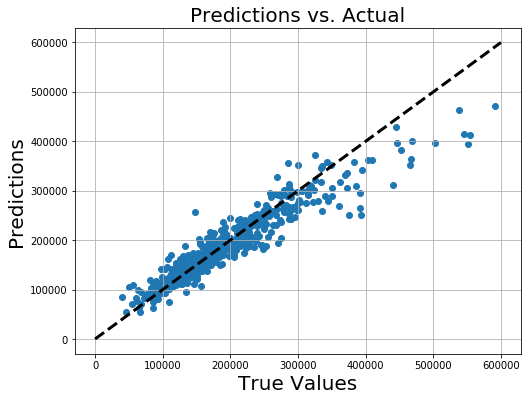

In [23]:
# set parameters
svm_params = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], # 'precomputed'
    'C' : [.5, 1, 3, 4, 5, 10]
}

svm_notes = 'Beginning Tuning'

# call the fit_model function
all_results, svm_best_model, svm_preds = fit_model(svm.SVR(), 'SVM', svm_params, all_results, svm_notes)


,Grad. Boost
Test score,0.83
Train score,0.843


,Grad. Boost
Best Params,"{'learning_rate': 0.1, 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}"
Params Tried,"{'learning_rate': [0.0075, 0.1, 0.125], 'n_estimators': [110, 125, 140], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_depth': [None], 'max_leaf_nodes': [None], 'max_features': ['auto']}"
Notes,


Runtime:  19.032  minutes


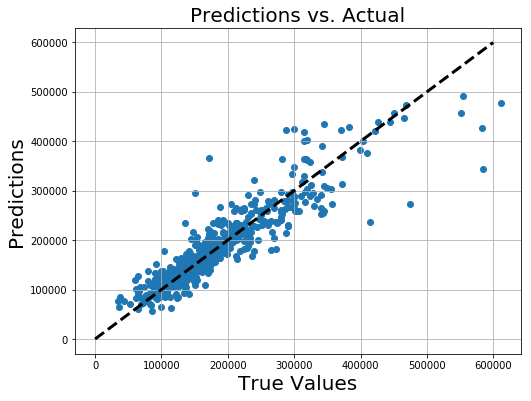

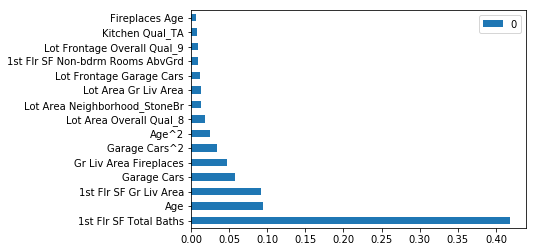

In [24]:
# set parameters
gb_params = {
            'learning_rate' : [.0075, 0.1, .125,],
            'n_estimators': [110, 125, 140],
            'min_samples_split': [2],
            'min_samples_leaf': [2],
#             'bootstrap': [True, False],
            'max_depth':[None],
            'max_leaf_nodes': [None],
            'max_features': ['auto'], # max_feat_to_check
}

gb_notes = ''

# call the fit_model function
all_results, gb_best_model, gb_preds = fit_model(GradientBoostingRegressor(), 
                                                 'Grad. Boost', 
                                                 gb_params, 
                                                 all_results, 
                                                 gb_notes
                                                )

# Top features
feat_importance = pd.DataFrame(gb_best_model.feature_importances_, index=all_features).sort_values(by=0, ascending=False)
feat_importance.head(15).plot(kind='barh')


,KNN
Test score,0.837
Train score,0.797


,KNN
Best Params,"{'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
Params Tried,"{'n_neighbors': [3, 4, 5, 7, 10, 15, 25], 'weights': ['uniform', 'distance'], 'metric': ['minkowski'], 'p': [1, 2, 3]}"
Notes,Beginning Tuning


Runtime:  9.889  minutes


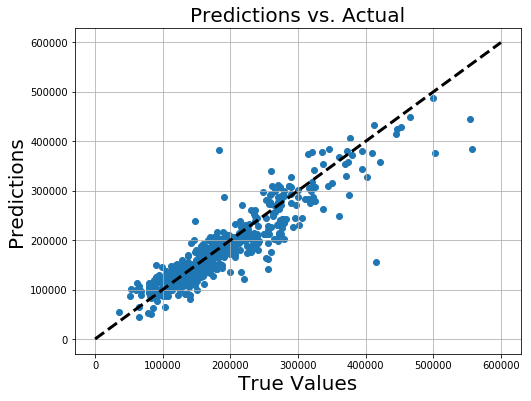

In [25]:
# set parameters
knn_params = {
    'n_neighbors': [3, 4, 5, 7, 10, 15, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2, 3] # p = 1 and 2 correspondes to Manhattan and Euclidean distance metrics repsectively
}

knn_notes = 'Beginning Tuning'

# call the fit_model function
all_results, knn_best_model, knn_preds = fit_model(KNeighborsRegressor(), 'KNN', knn_params, all_results, knn_notes)


# Overall Results:

In [26]:
display(all_results.head(2))
display(all_results.tail(3))

,Random Forest,SVM,Grad. Boost,KNN
Test score,0.853,0.883,0.83,0.837
Train score,0.863,0.829,0.843,0.797


,Random Forest,SVM,Grad. Boost,KNN
Best Params,"{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100}","{'C': 10, 'kernel': 'linear'}","{'learning_rate': 0.1, 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}","{'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
Params Tried,"{'n_estimators': [100], 'min_samples_split': [7], 'min_samples_leaf': [2], 'bootstrap': [True], 'max_depth': [None], 'max_leaf_nodes': [None], 'max_features': ['auto']}","{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.5, 1, 3, 4, 5, 10]}","{'learning_rate': [0.0075, 0.1, 0.125], 'n_estimators': [110, 125, 140], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_depth': [None], 'max_leaf_nodes': [None], 'max_features': ['auto']}","{'n_neighbors': [3, 4, 5, 7, 10, 15, 25], 'weights': ['uniform', 'distance'], 'metric': ['minkowski'], 'p': [1, 2, 3]}"
Notes,"Picked min_samples_leaf=1, bootstrap=True, n_estimators=100, min_samples_leaf=2",Beginning Tuning,,Beginning Tuning


# Make submission file:

In [27]:
# test['SalePrice'] = rf_best_model.predict(test_scaled_df)
# test[['Id', 'SalePrice']].sort_values(by='Id').to_csv('submissions.csv',index=False)

## Kaggle Submission Link:

https://www.kaggle.com/c/dsi-us-5-project-2-regression-challenge